Import csv file containing OECD and WHO data for analysis. We will use a single number that measures how efficiently each country turns its wealth into health outcomes for our target; HEI = z(LifeExpectacny) - z(GDP per capita (PPP)). By standardizing we can get the two measures on the same scale. If a country's life expectancy z-score is higher than its income z-score, its acheiving better health than its income predicts. Higher HEI means more efficient.

OECD and WHO indicators combined into one csv stored in Google Drive.

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
!pip install --upgrade scikit-learn

In [136]:
!pip install wbgapi


In [137]:
!pip install xgboost shap

In [138]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/MIS_545/HEI_DATA/HEI_DATA.csv")
df.head()

,Country,Life_expectancy,GDP_per_capita,Expenditure_per_capita,Expenditure_percent_GDP,Doctors_per_1000,Nurses_per_1000,Public_share_spending,Smoking_rate,Alcohol_consumption
0,Argentina,75.9,NaN,NaN,NaN,NaN,NaN,NaN,19.1,0.82
1,Australia,83.2,56963.30772,477.0,10.50,3.91,12.28,5.778,10.9,1.03
2,Austria,81.3,58522.84230,2115.0,3.52,5.32,10.47,6.995,24.0,0.00
3,Belgium,80.8,56119.61624,9769.0,2.06,3.21,11.60,6.986,24.5,0.29
4,Brazil,74.5,NaN,NaN,NaN,2.05,4.16,NaN,12.2,0.00


In [139]:
df.describe()

,Life_expectancy,GDP_per_capita,Expenditure_per_capita,Expenditure_percent_GDP,Doctors_per_1000,Nurses_per_1000,Public_share_spending,Smoking_rate,Alcohol_consumption
count,51.000000,38.000000,41.000000,41.000000,39.000000,39.000000,42.000000,45.000000,45.000000
mean,78.596078,49334.317816,3696.024390,13.844073,3.432051,8.497692,5.578143,19.100000,0.467340
std,4.450077,22990.328474,4966.022108,22.595097,1.065670,4.090526,1.929698,7.831463,1.386473
min,65.200000,15950.508980,28.000000,-2.137000,0.630000,1.020000,0.000000,1.500000,0.000000
25%,76.150000,32067.917440,477.000000,1.010000,2.795000,5.275000,4.294000,13.200000,0.000000
50%,80.600000,44380.567980,1883.000000,4.550000,3.420000,8.510000,5.717500,19.200000,0.120000
75%,82.250000,56987.232180,5531.000000,12.400000,4.320000,11.345000,6.992750,22.900000,0.390000
max,84.600000,136543.605200,20397.000000,100.000000,5.370000,18.370000,8.557000,38.700000,9.270000


In [140]:
df.isnull().sum()

,0
Country,0
Life_expectancy,0
GDP_per_capita,13
Expenditure_per_capita,10
Expenditure_percent_GDP,10
Doctors_per_1000,12
Nurses_per_1000,12
Public_share_spending,9
Smoking_rate,6
Alcohol_consumption,6


GDP per capita is needed to build our target HEI, drop countries without data. Also drop countries missing more than two X values.

In [141]:
df = df.dropna(subset=['GDP_per_capita'], how='any')      # require no missing values in specific columns
df = df.dropna(thresh=3)   # Keep rows that have at least 'thresh' non-missing values
df.sample(5)

,Country,Life_expectancy,GDP_per_capita,Expenditure_per_capita,Expenditure_percent_GDP,Doctors_per_1000,Nurses_per_1000,Public_share_spending,Smoking_rate,Alcohol_consumption
3,Belgium,80.8,56119.61624,9769.0,2.060,3.21,11.60,6.986,24.5,0.29
34,Norway,83.3,60737.87591,385.0,27.400,4.68,15.57,5.560,13.5,0.27
49,United Kingdom,80.3,51836.57306,20048.0,0.142,3.26,8.51,7.929,NaN,NaN
43,Spain,82.3,44342.31484,2580.0,3.920,4.57,5.88,6.761,27.5,0.20
13,Denmark,81.6,69355.38342,2612.0,13.100,4.38,10.24,7.217,16.1,0.00


In [142]:
df.isnull().sum()

,0
Country,0
Life_expectancy,0
GDP_per_capita,0
Expenditure_per_capita,0
Expenditure_percent_GDP,0
Doctors_per_1000,7
Nurses_per_1000,7
Public_share_spending,0
Smoking_rate,4
Alcohol_consumption,4


We can compute HEI on the remaining countries and impute the missing values in the upcoming pipeline.

In [143]:
from sklearn.model_selection import train_test_split

df = df.copy()
train_df, test_df = train_test_split(df, test_size=.25, random_state=42)

# define function to calculate zscores on train and test data
def z_params(s, mean, std):
  return (s - mean) / std if std != 0 else s*0

LE_mean, LE_std = train_df['Life_expectancy'].mean(), train_df['Life_expectancy'].std()
GDP_mean, GDP_std = train_df['GDP_per_capita'].mean(), train_df['GDP_per_capita'].std()

train_df['HEI'] = z_params(train_df['Life_expectancy'], LE_mean, LE_std) - z_params(train_df['GDP_per_capita'], GDP_mean, GDP_std)
test_df['HEI'] = z_params(test_df['Life_expectancy'], LE_mean, LE_std) - z_params(test_df['GDP_per_capita'], GDP_mean, GDP_std)
train_df.sample(5)

,Country,Life_expectancy,GDP_per_capita,Expenditure_per_capita,Expenditure_percent_GDP,Doctors_per_1000,Nurses_per_1000,Public_share_spending,Smoking_rate,Alcohol_consumption,HEI
37,Portugal,81.5,29548.18459,3327.0,2.230,NaN,NaN,6.669,20.7,0.36,1.293265
46,Türkiye,77.7,31338.37946,438.0,9.470,NaN,NaN,3.916,19.8,0.00,-0.155813
29,Lithuania,75.2,28854.00357,8140.0,0.917,4.46,7.76,4.952,21.6,0.39,-0.962198
19,Hungary,75.5,43879.85717,1022.0,0.955,3.33,5.32,5.007,28.1,0.00,-1.456433
2,Austria,81.3,58522.84230,2115.0,3.520,5.32,10.47,6.995,24.0,0.00,0.058070


Now we can separate the target and features, keeping country as the index (don't encode or feed to the model).

In [144]:
train_labels = train_df["Country"]
test_labels = test_df["Country"]

drop_cols = {"Country", "HEI", "Life_expectancy", "GDP_per_capita"}
feature_cols = [c for c in df.columns if c not in drop_cols]
X_train, y_train = train_df[feature_cols], train_df["HEI"]
X_test, y_test = test_df[feature_cols], test_df["HEI"]
X_train.head()

,Expenditure_per_capita,Expenditure_percent_GDP,Doctors_per_1000,Nurses_per_1000,Public_share_spending,Smoking_rate,Alcohol_consumption
24,6300.0,0.662,3.31,5.23,4.384,13.8,0.072
13,2612.0,13.100,4.38,10.24,7.217,16.1,0.000
23,1772.0,1.010,3.42,12.54,8.014,17.0,0.720
17,560.0,12.400,4.47,12.04,8.499,19.3,0.040
26,769.0,53.400,2.60,12.10,7.049,19.2,0.350


Define preprocessors for linear and tree models.

In [145]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


#linear: impute and scale
prep_linear = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler())
    ]), feature_cols)
], remainder="drop")

#trees: impute only
prep_tree = SimpleImputer(strategy="median")


In [146]:
#model pipelines
pipeline_linear = Pipeline([
    ("preprocessor", prep_linear),
    ("regressor", Ridge())
])

pipeline_rf = Pipeline([
    ("preprocessor", prep_tree),
    ("regressor", RandomForestRegressor(random_state=42, n_jobs=-1))
])

pipeline_xgb = Pipeline([
    ("preprocessor", prep_tree),
    ("regressor", XGBRegressor(
        objective="reg:squarederror",
        n_estimators=600,
        random_state=42,
        n_jobs=-1
    ))
])

In [147]:
# Hyperparamater grids
grids = {
    "linear": {
        "regressor__alpha": [0.1, 1, 3, 10, 30, 100]
    },
    "rf": {
        "regressor__n_estimators": [400, 800],
        "regressor__max_depth": [None, 8, 12],
        "regressor__min_samples_leaf": [1, 3, 5]
    },
    "xgb": {
        "regressor__n_estimators": [400, 800],
        "regressor__max_depth": [3, 5, 7],
        "regressor__learning_rate": [0.02, 0.05, 0.1],
        "regressor__subsample": [0.8, 1.0],
        "regressor__colsample_bytree": [0.8, 1.0],
        "regressor__reg_lambda": [1.0, 3.0, 5.0],
        "regressor__objective": ["reg:squarederror"]  # optional to be explicit
    }
}

In [148]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [149]:
# Grid search for best hyperparameters
def eval_with_cv(name, pipe, grid, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(
        pipe,
        grid,
        scoring="neg_mean_squared_error",  # <- safe across versions
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X, y)
    best = gs.best_estimator_

    # Recompute CV metrics on the best estimator
    r2s, rmses, maes = [], [], []
    for tr, te in cv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        best.fit(Xtr, ytr)
        pred = best.predict(Xte)
        r2s.append(r2_score(yte, pred))
        rmses.append(rmse(yte, pred))
        maes.append(mean_absolute_error(yte, pred))
    return {
        "model": name,
        "R2_mean":  float(np.mean(r2s)),  "R2_std":  float(np.std(r2s)),
        "RMSE_mean":float(np.mean(rmses)),"RMSE_std":float(np.std(rmses)),
        "MAE_mean": float(np.mean(maes)), "MAE_std": float(np.std(maes)),
        "best_params": gs.best_params_
    }, best
res_lin, best_lin = eval_with_cv("Ridge",        pipeline_linear, grids["linear"], X_train, y_train)
res_rf,  best_rf  = eval_with_cv("RandomForest", pipeline_rf,     grids["rf"],     X_train, y_train)
res_xgb, best_xgb = eval_with_cv("XGBoost",      pipeline_xgb,    grids["xgb"],    X_train, y_train)

results_cv = pd.DataFrame([res_lin, res_rf, res_xgb]).sort_values("RMSE_mean")
results_cv[["model","R2_mean","RMSE_mean","MAE_mean","best_params"]]

,model,R2_mean,RMSE_mean,MAE_mean,best_params
1,RandomForest,-0.070645,1.047848,0.847045,"{'regressor__max_depth': None, 'regressor__min..."
0,Ridge,-0.052042,1.054764,0.832532,{'regressor__alpha': 100}
2,XGBoost,-0.251978,1.112083,0.920705,"{'regressor__colsample_bytree': 0.8, 'regresso..."


In [150]:
# Evaluate
def eval_on_test(model, Xtr, ytr, Xte, yte, name):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    return {
        "model": name,
        "test_R2":  r2_score(yte, pred),
        "test_RMSE": rmse(yte, pred),
        "test_MAE":  mean_absolute_error(yte, pred)
    }

In [151]:
# results_cv is CV summary from GridSearch; pick by lowest RMSE
best_name = results_cv.sort_values("RMSE_mean").iloc[0]["model"]
best_model = {"Ridge": best_lin, "RandomForest": best_rf, "XGBoost": best_xgb}[best_name]

best_model.fit(X_train, y_train)
y_pred_test = best_model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np, pandas as pd

test_row = {
    "model": best_name,
    "test_R2":  r2_score(y_test, y_pred_test),
    "test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
    "test_MAE":  mean_absolute_error(y_test, y_pred_test)
}
pd.DataFrame([test_row])

,model,test_R2,test_RMSE,test_MAE
0,RandomForest,-0.228323,1.329513,0.984006


In [152]:
# Combine CV means with held-out test scores into one table
table = results_cv[["model","R2_mean","RMSE_mean","MAE_mean","best_params"]].copy()
table = table.merge(pd.DataFrame([test_row]), on="model", how="left")
table


,model,R2_mean,RMSE_mean,MAE_mean,best_params,test_R2,test_RMSE,test_MAE
0,RandomForest,-0.070645,1.047848,0.847045,"{'regressor__max_depth': None, 'regressor__min...",-0.228323,1.329513,0.984006
1,Ridge,-0.052042,1.054764,0.832532,{'regressor__alpha': 100},NaN,NaN,NaN
2,XGBoost,-0.251978,1.112083,0.920705,"{'regressor__colsample_bytree': 0.8, 'regresso...",NaN,NaN,NaN


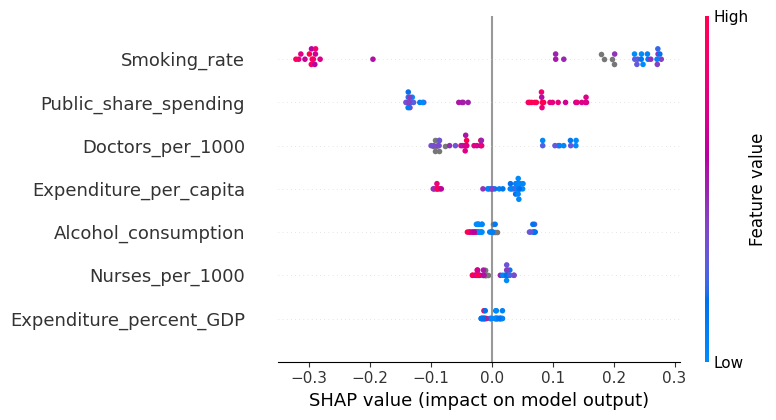

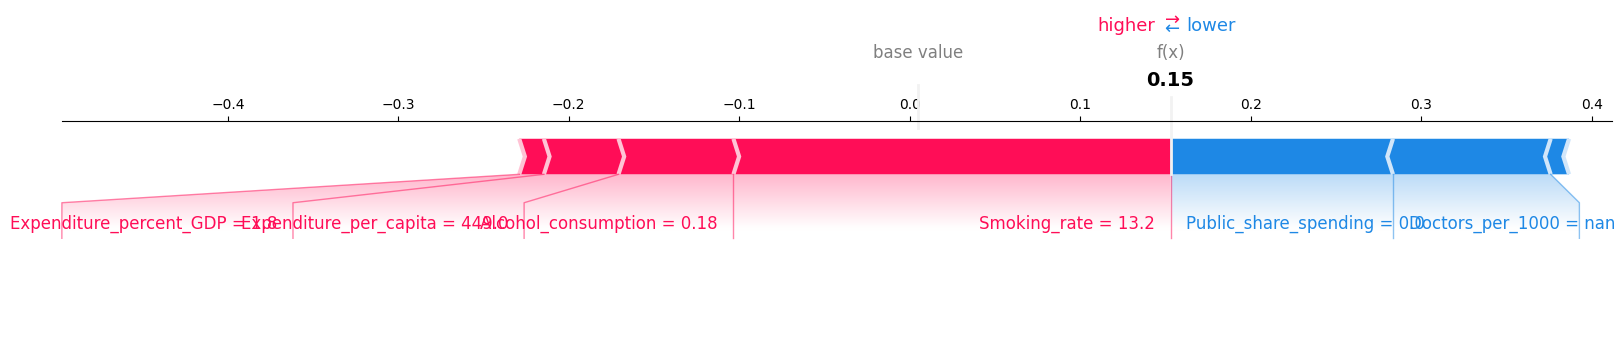

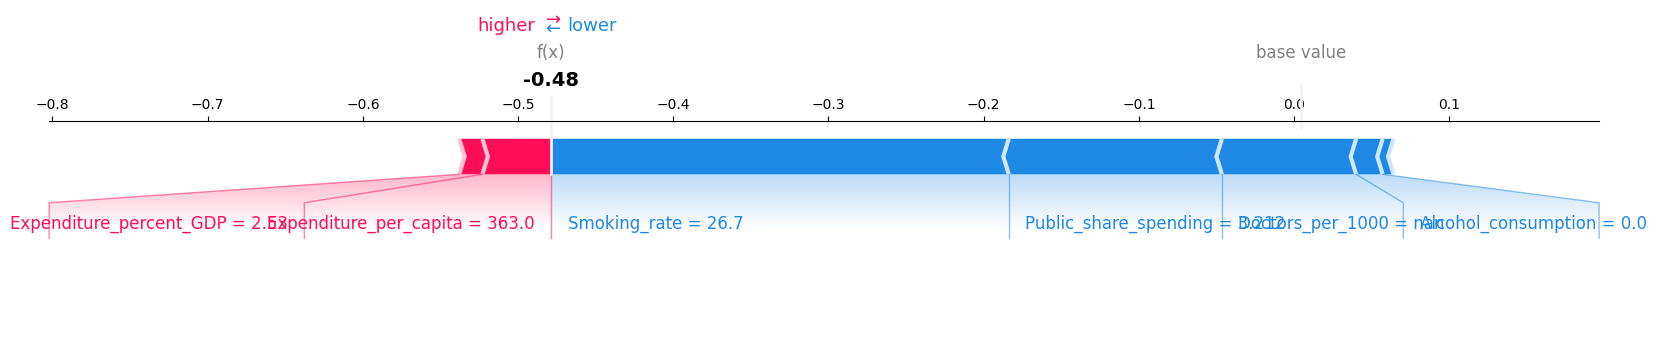

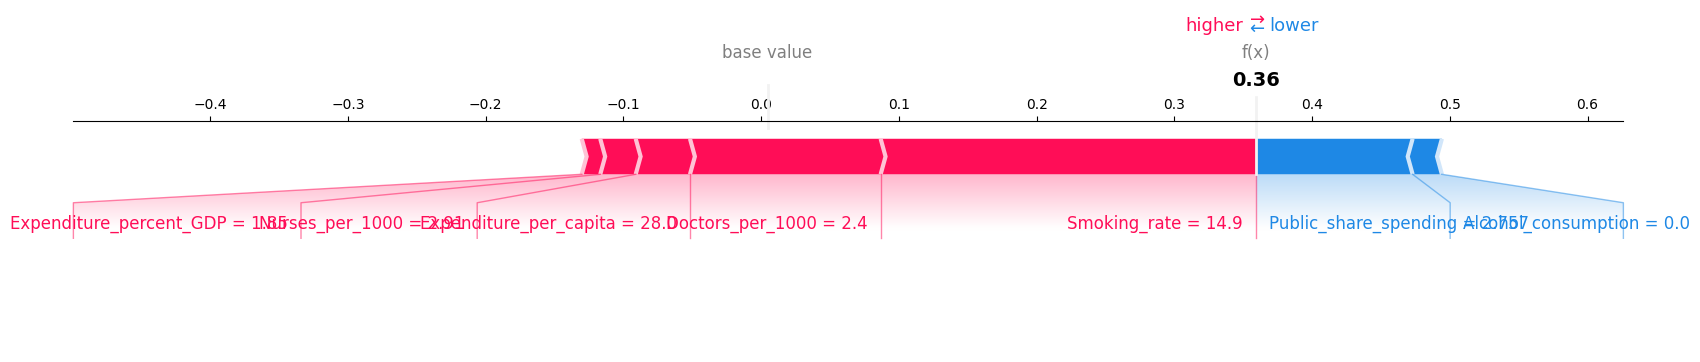

In [153]:
import shap
# get inner estimator and imputed matrix
prep = best_model.named_steps["preprocessor"]
X_imp = prep.fit_transform(pd.concat([X_train, X_test], ignore_index=True))
est  = best_model.named_steps["regressor"]

explainer = shap.TreeExplainer(est)
shap_values = explainer.shap_values(X_imp)

# Global importance
shap.summary_plot(shap_values, pd.concat([X_train, X_test]), show=True)

# Local examples for top 3 test errors
err_idx = np.argsort(np.abs(y_pred_test - y_test.values))[-3:]
for i in err_idx:
    shap.force_plot(explainer.expected_value, shap_values[len(X_train)+i, :],
                    X_test.iloc[i, :], matplotlib=True)


In [154]:
# Keep Country labels from earlier split
pd.set_option("display.max_rows", None)
pred_df = pd.DataFrame({
    "Country": test_df["Country"].values,
    "HEI_actual": y_test.values,
    "HEI_pred":   y_pred_test
})
pred_df.sort_values("HEI_pred", ascending=False)


,Country,HEI_actual,HEI_pred
8,Mexico,-3.026370,0.359333
1,United Kingdom,-0.036052,0.327186
9,Iceland,1.024489,0.315549
0,Sweden,0.309554,0.256082
7,Norway,0.694048,0.226832
6,Costa Rica,1.278851,0.178084
5,New Zealand,0.832793,0.079944
4,Slovak Republic,-0.362396,0.070104
3,Greece,0.906287,-0.187024
2,Chile,1.005699,-0.476364


In [155]:
# after selecting best_model and logged test metrics:
X_all = pd.concat([X_train, X_test], axis=0)
y_all = pd.concat([y_train, y_test], axis=0)
countries_all = pd.concat([train_df["Country"], test_df["Country"]], axis=0).reset_index(drop=True)

final_model = best_model  # same tuned pipeline
final_model.fit(X_all, y_all)

pred_all = pd.DataFrame({
    "Country": countries_all,
    "HEI": y_all.values,
    "HEI_pred": final_model.predict(X_all)
}).sort_values("HEI_pred", ascending=False)

pred_all
# Or export:
#pred_all.to_csv("final_ranking_all_countries.csv", index=False)


,Country,HEI,HEI_pred
7,Australia,0.809272,0.572502
37,Iceland,1.024489,0.507144
34,Costa Rica,1.278851,0.471632
35,Norway,0.694048,0.469399
4,Japan,1.820068,0.434656
20,Slovenia,0.894846,0.431219
23,Italy,1.268353,0.425223
15,Portugal,1.293265,0.414560
9,Colombia,0.099247,0.382040
17,Canada,0.228102,0.350024


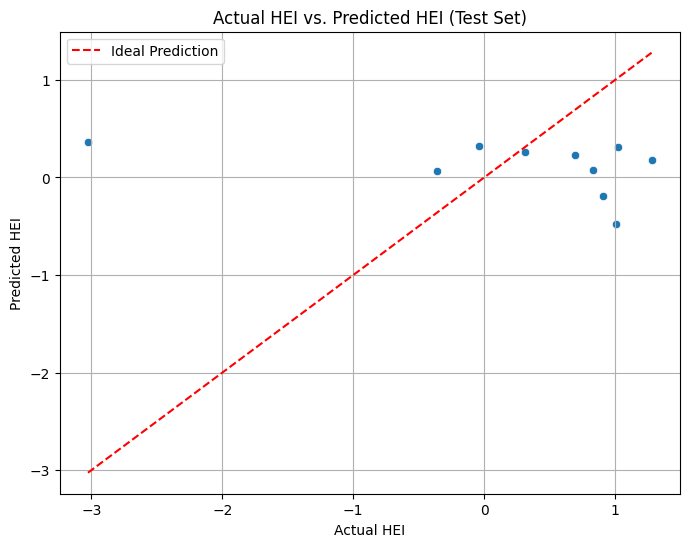

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x='HEI_actual', y='HEI_pred', data=pred_df)
plt.plot([pred_df['HEI_actual'].min(), pred_df['HEI_actual'].max()],
         [pred_df['HEI_actual'].min(), pred_df['HEI_actual'].max()],
         'r--', label='Ideal Prediction') # Add a diagonal line for ideal prediction
plt.title('Actual HEI vs. Predicted HEI (Test Set)')
plt.xlabel('Actual HEI')
plt.ylabel('Predicted HEI')
plt.grid(True)
plt.legend()
plt.show()

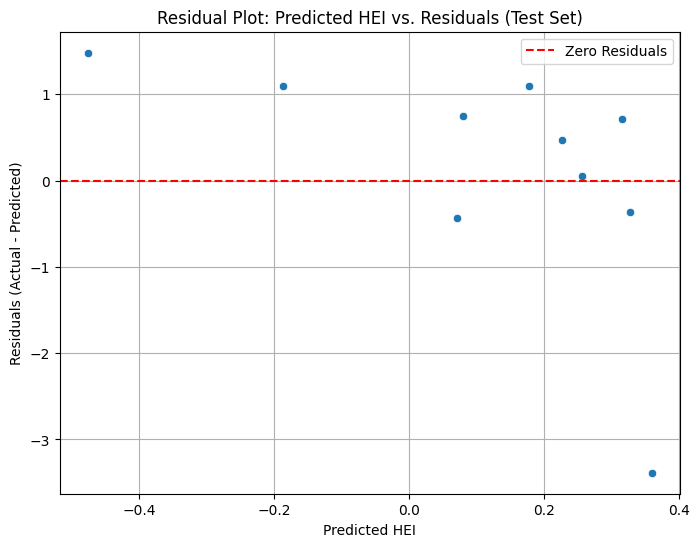

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

residuals = pred_df['HEI_actual'] - pred_df['HEI_pred']

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pred_df['HEI_pred'], y=residuals)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residuals') # Add a horizontal line at y=0
plt.title('Residual Plot: Predicted HEI vs. Residuals (Test Set)')
plt.xlabel('Predicted HEI')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.legend()
plt.show()

Poor performing model overall, adding data from World Bank World Development Indicators (WDI)

In [158]:
import wbgapi as wb

indicators = [
    'SH.STA.OB18.ZS',   # Obesity
    'SH.STA.DIAB.ZS',   # Diabetes
    'SH.IMM.MEAS',      # Immunization
    'SH.MED.BEDS.ZS',   # Hospital beds
    'SH.XPD.OOPC.CH.ZS',# Out-of-pocket spending
    'EN.ATM.PM25.MC.M3',# Air pollution
    'SP.URB.TOTL.IN.ZS',# Urbanization
    'SE.SEC.CMPT.LO.ZS',# Education
    'SI.POV.GINI',      # Gini
    'SI.POV.NAHC',      # Poverty headcount
    'SP.POP.DPND',      # Dependency ratio
    'SP.DYN.TFRT.IN'    # Fertility rate
]

# Pull data for 2020 for ALL economies
wdi_df = wb.data.DataFrame(indicators, time=2020).T

# Bring the country code out of the index into a column
wdi_df = wdi_df.reset_index()
wdi_df = wdi_df.rename(columns={"economy": "CountryCode"})

wdi_df.head()


economy,index,ABW,AFE,AFG,AFW,AGO,ALB,AND,ARB,ARE,...,VIR,VNM,VUT,WLD,WSM,XKX,YEM,ZAF,ZMB,ZWE
0,EN.ATM.PM25.MC.M3,NaN,26.755686,46.087094,54.891820,25.145238,15.707004,9.080281,39.713215,36.305503,...,8.633428,20.801064,14.082412,31.323166,12.551895,NaN,34.83236,23.753069,24.308592,19.494180
1,SE.SEC.CMPT.LO.ZS,90.171822,44.737320,NaN,42.091740,NaN,93.421487,92.713570,64.292480,103.876922,...,NaN,NaN,58.563438,77.216476,104.965939,NaN,NaN,86.668159,NaN,63.381481
2,SH.IMM.MEAS,NaN,73.244820,57.000000,64.807036,54.000000,91.000000,98.000000,82.992545,99.000000,...,NaN,97.000000,78.000000,83.878767,66.000000,NaN,53.00000,84.000000,96.000000,85.000000
3,SH.MED.BEDS.ZS,NaN,NaN,0.340000,NaN,NaN,2.910000,NaN,1.303822,1.940000,...,NaN,NaN,NaN,3.283742,NaN,NaN,NaN,NaN,NaN,NaN
4,SH.STA.DIAB.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
import pandas as pd

# Start from your current wdi_df
wdi_df_clean = wdi_df.copy()

# See the actual column names to confirm
print("Columns in wdi_df:", wdi_df_clean.columns.tolist())

# Treat the first column as the indicator code column (e.g. 'economy' or similar)
indicator_col = wdi_df_clean.columns[0]
print("Using this column as Indicator:", indicator_col)

# Melt to long format: one row per (Indicator, CountryCode)
wdi_long = wdi_df_clean.melt(
    id_vars=[indicator_col],
    var_name="CountryCode",
    value_name="Value"
)

# Rename that first column to 'Indicator' for clarity
wdi_long = wdi_long.rename(columns={indicator_col: "Indicator"})

wdi_long.head()


Columns in wdi_df: ['index', 'ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'ALB', 'AND', 'ARB', 'ARE', 'ARG', 'ARM', 'ASM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CEB', 'CHE', 'CHI', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'COM', 'CPV', 'CRI', 'CSS', 'CUB', 'CUW', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'ECU', 'EGY', 'EMU', 'ERI', 'ESP', 'EST', 'ETH', 'EUU', 'FCS', 'FIN', 'FJI', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUM', 'GUY', 'HIC', 'HKG', 'HND', 'HPC', 'HRV', 'HTI', 'HUN', 'IBD', 'IBT', 'IDA', 'IDB', 'IDN', 'IDX', 'IMN', 'IND', 'INX', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAC', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LCN', 'LDC', 'LIC', 'LIE', 'LKA'

,Indicator,CountryCode,Value
0,EN.ATM.PM25.MC.M3,ABW,NaN
1,SE.SEC.CMPT.LO.ZS,ABW,90.171822
2,SH.IMM.MEAS,ABW,NaN
3,SH.MED.BEDS.ZS,ABW,NaN
4,SH.STA.DIAB.ZS,ABW,NaN


In [160]:
wdi_wide = wdi_long.pivot_table(
    index="CountryCode",
    columns="Indicator",
    values="Value"
).reset_index()

wdi_wide.head()


Indicator,CountryCode,EN.ATM.PM25.MC.M3,SE.SEC.CMPT.LO.ZS,SH.IMM.MEAS,SH.MED.BEDS.ZS,SH.XPD.OOPC.CH.ZS,SI.POV.GINI,SI.POV.NAHC,SP.DYN.TFRT.IN,SP.POP.DPND,SP.URB.TOTL.IN.ZS
0,ABW,NaN,90.171822,NaN,NaN,NaN,NaN,NaN,1.662000,48.878469,43.697000
1,AFE,26.755686,44.737320,73.244820,NaN,15.440980,NaN,NaN,4.412973,81.433777,36.884034
2,AFG,46.087094,NaN,57.000000,0.34,74.813965,NaN,NaN,5.145000,87.247817,26.026000
3,AFW,54.891820,42.091740,64.807036,NaN,58.049101,NaN,NaN,4.707399,84.798862,47.931021
4,AGO,25.145238,NaN,54.000000,NaN,28.661709,NaN,NaN,5.371000,91.369827,66.825000


In [161]:
nice_names = {
    'SH.STA.OB18.ZS':   'Obesity_rate',
    'SH.STA.DIAB.ZS':   'Diabetes_rate',
    'SH.IMM.MEAS':      'Immunization_measles',
    'SH.MED.BEDS.ZS':   'Hospital_beds',
    'SH.XPD.OOPC.CH.ZS':'OOP_health_share',
    'EN.ATM.PM25.MC.M3':'PM25',
    'SP.URB.TOTL.IN.ZS':'Urban_rate',
    'SE.SEC.CMPT.LO.ZS':'Sec_ed_completion',
    'SI.POV.GINI':      'Gini',
    'SI.POV.NAHC':      'Poverty_rate',
    'SP.POP.DPND':      'Dependency_ratio',
    'SP.DYN.TFRT.IN':   'Fertility_rate'
}

rename_map = {col: nice_names.get(col, col) for col in wdi_wide.columns}
wdi_wide = wdi_wide.rename(columns=rename_map)

wdi_wide.head()


Indicator,CountryCode,PM25,Sec_ed_completion,Immunization_measles,Hospital_beds,OOP_health_share,Gini,Poverty_rate,Fertility_rate,Dependency_ratio,Urban_rate
0,ABW,NaN,90.171822,NaN,NaN,NaN,NaN,NaN,1.662000,48.878469,43.697000
1,AFE,26.755686,44.737320,73.244820,NaN,15.440980,NaN,NaN,4.412973,81.433777,36.884034
2,AFG,46.087094,NaN,57.000000,0.34,74.813965,NaN,NaN,5.145000,87.247817,26.026000
3,AFW,54.891820,42.091740,64.807036,NaN,58.049101,NaN,NaN,4.707399,84.798862,47.931021
4,AGO,25.145238,NaN,54.000000,NaN,28.661709,NaN,NaN,5.371000,91.369827,66.825000


In [162]:
import wbgapi as wb
import pandas as pd

# Get a DataFrame of economy information directly
economy_info_df = wb.economy.DataFrame()

# Create the country name to code mapping: map 'name' column to the DataFrame's index ('id')
country_name_to_code = pd.Series(economy_info_df.index.values, index=economy_info_df['name']).to_dict()

# Add 'CountryCode' to df based on its 'Country' column
df['CountryCode'] = df['Country'].map(country_name_to_code)

# Now, perform the merge
merged = df.merge(wdi_wide, on="CountryCode", how="left")

merged.info()
merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  38 non-null     object 
 1   Life_expectancy          38 non-null     float64
 2   GDP_per_capita           38 non-null     float64
 3   Expenditure_per_capita   38 non-null     float64
 4   Expenditure_percent_GDP  38 non-null     float64
 5   Doctors_per_1000         31 non-null     float64
 6   Nurses_per_1000          31 non-null     float64
 7   Public_share_spending    38 non-null     float64
 8   Smoking_rate             34 non-null     float64
 9   Alcohol_consumption      34 non-null     float64
 10  CountryCode              36 non-null     object 
 11  PM25                     36 non-null     float64
 12  Sec_ed_completion        29 non-null     float64
 13  Immunization_measles     36 non-null     float64
 14  Hospital_beds            34 

,Country,Life_expectancy,GDP_per_capita,Expenditure_per_capita,Expenditure_percent_GDP,Doctors_per_1000,Nurses_per_1000,Public_share_spending,Smoking_rate,Alcohol_consumption,...,PM25,Sec_ed_completion,Immunization_measles,Hospital_beds,OOP_health_share,Gini,Poverty_rate,Fertility_rate,Dependency_ratio,Urban_rate
0,Australia,83.2,56963.30772,477.0,10.50,3.91,12.28,5.778,10.9,1.03,...,8.251717,NaN,93.0,NaN,14.886137,33.8,NaN,1.581,53.606125,86.241
1,Austria,81.3,58522.84230,2115.0,3.52,5.32,10.47,6.995,24.0,0.00,...,10.933514,96.118813,95.0,7.06,16.471933,29.8,14.7,1.440,50.518408,58.748
2,Belgium,80.8,56119.61624,9769.0,2.06,3.21,11.60,6.986,24.5,0.29,...,11.216066,93.466339,96.0,5.52,17.189375,26.0,12.7,1.550,56.309617,98.079
3,Canada,81.6,56995.20700,6371.0,5.34,2.73,10.07,7.363,12.0,0.68,...,6.565670,NaN,90.0,2.56,13.710943,29.9,NaN,1.410,51.198350,81.562
4,Chile,80.8,30392.08970,363.0,2.53,NaN,NaN,3.212,26.7,0.00,...,23.275067,99.446693,91.0,2.03,29.042452,47.0,10.7,1.307,45.010823,87.727


In [163]:
pd.DataFrame({
    "MissingCount": merged.isna().sum(),
    "MissingPercent": (merged.isna().mean()*100).round(1)
}).sort_values("MissingPercent", ascending=False)


,MissingCount,MissingPercent
Poverty_rate,12,31.6
Sec_ed_completion,9,23.7
Nurses_per_1000,7,18.4
Doctors_per_1000,7,18.4
Gini,5,13.2
Alcohol_consumption,4,10.5
Hospital_beds,4,10.5
Smoking_rate,4,10.5
OOP_health_share,2,5.3
Dependency_ratio,2,5.3


In [164]:
import numpy as np

# Standardize life expectancy and GDP per capita
life_z = (merged["Life_expectancy"] - merged["Life_expectancy"].mean()) / merged["Life_expectancy"].std()
gdp_z  = (merged["GDP_per_capita"] - merged["GDP_per_capita"].mean()) / merged["GDP_per_capita"].std()

# Define HEI as z(LifeExpectancy) - z(GDP per capita)
merged["HEI_zdiff"] = life_z - gdp_z

# Now you can use this as your target:
y = merged["HEI_zdiff"]


In [165]:
feature_cols = [
    'Expenditure_per_capita',
    'Expenditure_percent_GDP',
    'Doctors_per_1000',
    'Nurses_per_1000',
    'Public_share_spending',
    'Smoking_rate',
    'Alcohol_consumption',
    'Hospital_beds',
    'OOP_health_share',
    'PM25',
    'Urban_rate',
    'Sec_ed_completion',
    'Gini',
    'Poverty_rate',
    'Dependency_ratio',
    'Fertility_rate',
    'Immunization_measles'
]

X = merged[feature_cols]
y = merged["HEI_zdiff"]


In [166]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

X_train.shape, X_test.shape

((28, 17), (10, 17))

In [167]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [168]:
prep_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler())
        ]), X.columns.tolist())
    ],
    remainder="drop"
)

pipeline_linear = Pipeline([
    ("preprocessor", prep_linear),
    ("regressor", Ridge())
])

In [169]:
prep_tree = Pipeline([
    ("imp", SimpleImputer(strategy="median"))
])

pipeline_rf = Pipeline([
    ("preprocessor", prep_tree),
    ("regressor", RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

pipeline_xgb = Pipeline([
    ("preprocessor", prep_tree),
    ("regressor", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_estimators=400,
        n_jobs=-1
    ))
])

In [170]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

grids = {
    "Ridge": {
        "regressor__alpha": [0.1, 1, 3, 10, 30]
    },
    "RandomForest": {
        "regressor__n_estimators": [300, 600],
        "regressor__max_depth": [None, 6, 10],
        "regressor__min_samples_leaf": [1, 3]
    },
    "XGBoost": {
        "regressor__n_estimators": [400, 800],
        "regressor__max_depth": [3, 5],
        "regressor__learning_rate": [0.03, 0.07],
        "regressor__subsample": [0.8, 1.0],
        "regressor__colsample_bytree": [0.8, 1.0],
        "regressor__reg_lambda": [1.0, 3.0]
    }
}

models = {
    "Ridge": pipeline_linear,
    "RandomForest": pipeline_rf,
    "XGBoost": pipeline_xgb
}

def eval_with_cv(name, pipe, grid, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(
        pipe,
        grid,
        scoring="neg_mean_squared_error",   # will convert to RMSE manually
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X, y)
    best = gs.best_estimator_

    r2s, rmses, maes = [], [], []
    for tr, te in cv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        best.fit(Xtr, ytr)
        pred = best.predict(Xte)
        r2s.append(r2_score(yte, pred))
        rmses.append(np.sqrt(mean_squared_error(yte, pred)))
        maes.append(mean_absolute_error(yte, pred))

    return {
        "model": name,
        "R2_mean": np.mean(r2s),
        "RMSE_mean": np.mean(rmses),
        "MAE_mean": np.mean(maes),
        "best_params": gs.best_params_
    }, best


In [171]:
res_lin, best_lin = eval_with_cv("Ridge",        models["Ridge"],        grids["Ridge"],        X_train, y_train)
res_rf,  best_rf  = eval_with_cv("RandomForest", models["RandomForest"], grids["RandomForest"], X_train, y_train)
res_xgb, best_xgb = eval_with_cv("XGBoost",      models["XGBoost"],      grids["XGBoost"],      X_train, y_train)

results_cv = pd.DataFrame([res_lin, res_rf, res_xgb]).sort_values("RMSE_mean")
results_cv


,model,R2_mean,RMSE_mean,MAE_mean,best_params
2,XGBoost,0.123143,0.940539,0.805057,"{'regressor__colsample_bytree': 1.0, 'regresso..."
1,RandomForest,0.086110,0.968502,0.802360,"{'regressor__max_depth': 6, 'regressor__min_sa..."
0,Ridge,-0.023811,1.000626,0.808644,{'regressor__alpha': 30}


Still a failing model. After further analysis, it appears that the problem is the target picking up too much noise and not enough signal. A more common model used in research is a Residual Life Expectancy Model. First, we will regress life expectancy on GDP per capita. Then we will compute the residuals : HEI Residual = Life Expectancy - Predicted Life Expectancy. The interpretation - positive value means live longer than expected for income. Negative means live shorter than expected. This is the same method used in Papanicolas et al. (JAMA, 2018) and OECD "Value for Money in Healthcare"

In [172]:
import numpy as np
import statsmodels.api as sm

# log GDP improves linearity
X_gdp = sm.add_constant(np.log(merged["GDP_per_capita"]))
model_gdp = sm.OLS(merged["Life_expectancy"], X_gdp).fit()

# predicted LE from income alone
merged["LE_pred_income"] = model_gdp.predict(X_gdp)

# residual = actual - predicted
merged["HEI_residual_income"] = merged["Life_expectancy"] - merged["LE_pred_income"]

merged[["Country", "Life_expectancy", "LE_pred_income", "HEI_residual_income"]].head()


,Country,Life_expectancy,LE_pred_income,HEI_residual_income
0,Australia,83.2,81.243546,1.956454
1,Austria,81.3,81.349792,-0.049792
2,Belgium,80.8,81.184849,-0.384849
3,Canada,81.6,81.245748,0.354252
4,Chile,80.8,78.772360,2.027640


In [173]:
y = merged["HEI_residual_income"]

In [174]:
merged["HEI_residual_income"].describe()

,HEI_residual_income
count,3.800000e+01
mean,1.346291e-14
std,2.679306e+00
min,-8.842735e+00
25%,-1.129681e+00
50%,2.007149e-01
75%,1.918359e+00
max,4.334914e+00


In [175]:
# Define final feature list
feature_cols = [
    'Expenditure_per_capita',
    'Expenditure_percent_GDP',
    'Doctors_per_1000',
    'Nurses_per_1000',
    'Public_share_spending',
    'Smoking_rate',
    'Alcohol_consumption',
    'Hospital_beds',
    'OOP_health_share',
    'PM25',
    'Urban_rate',
    'Sec_ed_completion',
    'Gini',
    'Poverty_rate',
    'Dependency_ratio',
    'Fertility_rate',
    'Immunization_measles'
]

X = merged[feature_cols]
y = merged["HEI_residual_income"]


In [176]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

In [177]:
prep_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), feature_cols)
    ]
)

pipeline_linear = Pipeline([
    ("preprocessor", prep_linear),
    ("regressor", Ridge())
])

In [178]:
prep_tree = Pipeline([
    ("imp", SimpleImputer(strategy="median"))
])

pipeline_rf = Pipeline([
    ("preprocessor", prep_tree),
    ("regressor", RandomForestRegressor(
        random_state=42, n_jobs=-1
    ))
])

pipeline_xgb = Pipeline([
    ("preprocessor", prep_tree),
    ("regressor", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_estimators=400,
        n_jobs=-1
    ))
])

In [179]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

grids = {
    "Ridge": {
        "regressor__alpha": [0.1, 1, 3, 10, 30]
    },
    "RandomForest": {
        "regressor__n_estimators": [300, 600],
        "regressor__max_depth": [None, 6, 10],
        "regressor__min_samples_leaf": [1, 3]
    },
    "XGBoost": {
        "regressor__max_depth": [3, 5],
        "regressor__learning_rate": [0.03, 0.07],
        "regressor__subsample": [0.8, 1.0],
        "regressor__colsample_bytree": [0.8, 1.0],
        "regressor__reg_lambda": [1.0, 3.0]
    }
}

models = {
    "Ridge": pipeline_linear,
    "RandomForest": pipeline_rf,
    "XGBoost": pipeline_xgb
}

def eval_with_cv(name, pipe, grid, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(
        pipe,
        grid,
        scoring="neg_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X, y)
    best = gs.best_estimator_

    r2s, rmses, maes = [], [], []
    for tr, te in cv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        best.fit(Xtr, ytr)
        pred = best.predict(Xte)
        r2s.append(r2_score(yte, pred))
        rmses.append(np.sqrt(mean_squared_error(yte, pred)))
        maes.append(mean_absolute_error(yte, pred))

    return {
        "model": name,
        "R2_mean": np.mean(r2s),
        "RMSE_mean": np.mean(rmses),
        "MAE_mean": np.mean(maes),
        "best_params": gs.best_params_
    }, best

In [180]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

grids = {
    "Ridge": {
        "regressor__alpha": [0.1, 1, 3, 10, 30]
    },
    "RandomForest": {
        "regressor__n_estimators": [300, 600],
        "regressor__max_depth": [None, 6, 10],
        "regressor__min_samples_leaf": [1, 3]
    },
    "XGBoost": {
        "regressor__max_depth": [3, 5],
        "regressor__learning_rate": [0.03, 0.07],
        "regressor__subsample": [0.8, 1.0],
        "regressor__colsample_bytree": [0.8, 1.0],
        "regressor__reg_lambda": [1.0, 3.0]
    }
}

models = {
    "Ridge": pipeline_linear,
    "RandomForest": pipeline_rf,
    "XGBoost": pipeline_xgb
}

def eval_with_cv(name, pipe, grid, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(
        pipe,
        grid,
        scoring="neg_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X, y)
    best = gs.best_estimator_

    r2s, rmses, maes = [], [], []
    for tr, te in cv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        best.fit(Xtr, ytr)
        pred = best.predict(Xte)
        r2s.append(r2_score(yte, pred))
        rmses.append(np.sqrt(mean_squared_error(yte, pred)))
        maes.append(mean_absolute_error(yte, pred))

    return {
        "model": name,
        "R2_mean": np.mean(r2s),
        "RMSE_mean": np.mean(rmses),
        "MAE_mean": np.mean(maes),
        "best_params": gs.best_params_
    }, best

In [181]:
res_lin, best_lin = eval_with_cv("Ridge",        models["Ridge"],        grids["Ridge"],        X_train, y_train)
res_rf,  best_rf  = eval_with_cv("RandomForest", models["RandomForest"], grids["RandomForest"], X_train, y_train)
res_xgb, best_xgb = eval_with_cv("XGBoost",      models["XGBoost"],      grids["XGBoost"],      X_train, y_train)

results_cv = pd.DataFrame([res_lin, res_rf, res_xgb]).sort_values("R2_mean", ascending=False)
results_cv


,model,R2_mean,RMSE_mean,MAE_mean,best_params
0,Ridge,-0.237016,2.497191,2.055507,{'regressor__alpha': 30}
1,RandomForest,-0.258394,2.506926,2.051369,"{'regressor__max_depth': None, 'regressor__min..."
2,XGBoost,-0.626476,2.798917,2.320118,"{'regressor__colsample_bytree': 0.8, 'regresso..."


In [182]:
best_name = results_cv.iloc[0]["model"]
best_model = {
    "Ridge": best_lin,
    "RandomForest": best_rf,
    "XGBoost": best_xgb
}[best_name]

best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)

test_R2   = r2_score(y_test, pred)
test_RMSE = np.sqrt(mean_squared_error(y_test, pred))
test_MAE  = mean_absolute_error(y_test, pred)

pd.DataFrame([{
    "model": best_name,
    "test_R2": test_R2,
    "test_RMSE": test_RMSE,
    "test_MAE": test_MAE
}])


,model,test_R2,test_RMSE,test_MAE
0,Ridge,0.029003,3.2698,2.33109


The model is no longer broken, but the low R^2 indicates we are still missing explanatory information. We will add additional indicators from WHO.

In [183]:
import pandas as pd
import requests

def add_who_indicator(indicator_code, value_name):
    """
    Pulls a WHO GHO indicator via the GHO API, keeps latest year per country,
    and merges it into your `merged` DataFrame on CountryCode (ISO3).
    """
    url = f"https://ghoapi.azureedge.net/api/{indicator_code}"
    r = requests.get(url).json()

    df = pd.DataFrame.from_records(r["value"])

    # Keep relevant columns only
    df = df[["SpatialDim", "TimeDim", "NumericValue"]].rename(
        columns={
            "SpatialDim": "CountryCode",
            "TimeDim": "Year",
            "NumericValue": value_name
        }
    )

    # ISO3 code formatting
    df["CountryCode"] = df["CountryCode"].str.upper()

    # Keep the **latest year** for each country
    df = df.sort_values("Year").drop_duplicates("CountryCode", keep="last")

    # Merge into your master dataset
    global merged
    merged = merged.merge(df[["CountryCode", value_name]], on="CountryCode", how="left")


In [184]:
add_who_indicator("NCD_DIABETES_PREVALENCE_AGESTD", "Diabetes_rate")
add_who_indicator("NCD_HYP_PREVALENCE_A", "Hypertension_prevalence")
add_who_indicator("BP_04", "Raised_BP_rate")
add_who_indicator("NCDMORT3070", "NCD_mortality_30to70")
add_who_indicator("NCD_BMI_30A", "Obesity_rate")


In [185]:
merged[[
    "Country", "CountryCode",
    "Obesity_rate",
    "Diabetes_rate",
    "Hypertension_prevalence",
    "Raised_BP_rate",
    "NCD_mortality_30to70"
]].head()


,Country,CountryCode,Obesity_rate,Diabetes_rate,Hypertension_prevalence,Raised_BP_rate,NCD_mortality_30to70
0,Australia,AUS,30.243906,10.473412,26.3,24.233366,8.3
1,Austria,AUT,18.450151,7.489549,33.8,24.641569,7.4
2,Belgium,BEL,20.025368,6.716999,33.8,18.623219,9.2
3,Canada,CAN,26.227117,10.958136,19.9,8.593183,9.7
4,Chile,CHL,33.398509,16.307613,36.1,23.891193,11.2


In [186]:
merged[[
    "Obesity_rate",
    "Diabetes_rate",
    "Hypertension_prevalence",
    "Raised_BP_rate",
    "NCD_mortality_30to70"
]].isna().sum()


,0
Obesity_rate,2
Diabetes_rate,2
Hypertension_prevalence,2
Raised_BP_rate,2
NCD_mortality_30to70,2


In [187]:
feature_cols = [
    'Expenditure_per_capita',
    'Expenditure_percent_GDP',
    'Doctors_per_1000',
    'Nurses_per_1000',
    'Public_share_spending',
    'Smoking_rate',
    'Alcohol_consumption',
    'Hospital_beds',
    'OOP_health_share',
    'PM25',
    'Urban_rate',
    'Sec_ed_completion',
    'Gini',
    'Poverty_rate',
    'Dependency_ratio',
    'Fertility_rate',
    'Immunization_measles',

    # WHO indicators
    'Obesity_rate',
    'Diabetes_rate',
    'Hypertension_prevalence',
    'Raised_BP_rate',
    'NCD_mortality_30to70'
]


In [188]:
y = merged["HEI_residual_income"]
X = merged[feature_cols]

In [189]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [190]:
prep_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), feature_cols)
    ]
)

pipeline_linear = Pipeline([
    ("preprocessor", prep_linear),
    ("regressor", Ridge())
])

In [191]:
prep_tree = Pipeline([
    ("imp", SimpleImputer(strategy="median"))
])

pipeline_rf = Pipeline([
    ("preprocessor", prep_tree),
    ("regressor", RandomForestRegressor(random_state=42, n_jobs=-1))
])

pipeline_xgb = Pipeline([
    ("preprocessor", prep_tree),
    ("regressor", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_estimators=400,
        n_jobs=-1
    ))
])

In [192]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

grids = {
    "Ridge": {
        "regressor__alpha": [0.1, 1, 3, 10, 30]
    },
    "RandomForest": {
        "regressor__n_estimators": [300, 600],
        "regressor__max_depth": [None, 6, 10],
        "regressor__min_samples_leaf": [1, 3]
    },
    "XGBoost": {
        "regressor__max_depth": [3, 5],
        "regressor__learning_rate": [0.03, 0.07],
        "regressor__subsample": [0.8, 1.0],
        "regressor__colsample_bytree": [0.8, 1.0],
        "regressor__reg_lambda": [1.0, 3.0]
    }
}

models = {
    "Ridge": pipeline_linear,
    "RandomForest": pipeline_rf,
    "XGBoost": pipeline_xgb
}

def eval_with_cv(name, pipe, grid, X, y):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(
        pipe, grid,
        scoring="neg_mean_squared_error",
        cv=cv, n_jobs=-1, verbose=0
    )
    gs.fit(X, y)
    best = gs.best_estimator_

    r2s, rmses, maes = [], [], []
    for tr, te in cv.split(X):
        Xtr, Xte = X.iloc[tr], X.iloc[te]
        ytr, yte = y.iloc[tr], y.iloc[te]
        best.fit(Xtr, ytr)
        pred = best.predict(Xte)
        r2s.append(r2_score(yte, pred))
        rmses.append(np.sqrt(mean_squared_error(yte, pred)))
        maes.append(mean_absolute_error(yte, pred))

    return {
        "model": name,
        "R2_mean": np.mean(r2s),
        "RMSE_mean": np.mean(rmses),
        "MAE_mean": np.mean(maes),
        "best_params": gs.best_params_
    }, best


In [193]:
res_lin, best_lin = eval_with_cv("Ridge", models["Ridge"], grids["Ridge"], X_train, y_train)
res_rf, best_rf = eval_with_cv("RandomForest", models["RandomForest"], grids["RandomForest"], X_train, y_train)
res_xgb, best_xgb = eval_with_cv("XGBoost", models["XGBoost"], grids["XGBoost"], X_train, y_train)

results_cv = pd.DataFrame([res_lin, res_rf, res_xgb]).sort_values("R2_mean", ascending=False)
results_cv


,model,R2_mean,RMSE_mean,MAE_mean,best_params
0,Ridge,0.149481,2.053774,1.671338,{'regressor__alpha': 30}
1,RandomForest,0.022897,2.190425,1.889684,"{'regressor__max_depth': None, 'regressor__min..."
2,XGBoost,0.007920,2.211660,1.906089,"{'regressor__colsample_bytree': 0.8, 'regresso..."


In [194]:
best_name = results_cv.iloc[0]["model"]
best_model = {"Ridge": best_lin, "RandomForest": best_rf, "XGBoost": best_xgb}[best_name]

best_model.fit(X_train, y_train)
pred = best_model.predict(X_test)

test_R2 = r2_score(y_test, pred)
test_RMSE = np.sqrt(mean_squared_error(y_test, pred))
test_MAE  = mean_absolute_error(y_test, pred)

pd.DataFrame([{
    "model": best_name,
    "test_R2": test_R2,
    "test_RMSE": test_RMSE,
    "test_MAE": test_MAE
}])


,model,test_R2,test_RMSE,test_MAE
0,Ridge,-0.027998,3.364407,2.500897


In [195]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

X = merged[feature_cols].values
y = merged["HEI_residual_income"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [196]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

def build_model():
    model = Sequential([
        Dense(12, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_scaled.shape[1],)),
        Dropout(0.2),
        Dense(1)   # linear output for regression
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='mse',
        metrics=['mae']
    )
    return model


In [197]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Raw feature matrix
X_raw = merged[feature_cols].values
y = merged["HEI_residual_income"].values

# 1) Impute (median is good for these indicators)
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X_raw)

# 2) Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# Sanity check
np.isnan(X_scaled).sum(), np.isnan(y).sum()


(np.int64(0), np.int64(0))

In [198]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

def build_model():
    model = Sequential([
        Dense(12, activation='relu',
              kernel_regularizer=l2(0.01),
              input_shape=(X_scaled.shape[1],)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='mse',
        metrics=['mae']
    )
    return model

kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_preds = np.zeros_like(y, dtype=float)

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = build_model()
    es = tf.keras.callbacks.EarlyStopping(
        patience=30,
        restore_best_weights=True,
        verbose=0
    )

    model.fit(
        X_train, y_train,
        epochs=500,
        batch_size=8,
        verbose=0,
        callbacks=[es]
    )

    fold_preds = model.predict(X_test, verbose=0).flatten()
    all_preds[test_idx] = fold_preds

nn_R2   = r2_score(y, all_preds)
nn_RMSE = np.sqrt(mean_squared_error(y, all_preds))
nn_MAE  = mean_absolute_error(y, all_preds)

nn_results = pd.DataFrame([{
    "NN_R2": nn_R2,
    "NN_RMSE": nn_RMSE,
    "NN_MAE": nn_MAE
}])
nn_results


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


,NN_R2,NN_RMSE,NN_MAE
0,-0.652567,3.398685,2.474758


Attempted a neural network, did not work well with this model.

In [199]:
# Make sure these are DataFrames
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)


In [200]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# Make sure X_train and X_test are DataFrames with the correct columns
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

# Fresh preprocessor tied exactly to feature_cols
prep_linear_fresh = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc",  StandardScaler())
        ]), feature_cols)
    ]
)

# Use alpha=30 from your CV best_params
best_ridge = Pipeline([
    ("preprocessor", prep_linear_fresh),
    ("regressor", Ridge(alpha=30))
])

best_ridge.fit(X_train_df, y_train)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [201]:
prep = best_ridge.named_steps["preprocessor"]

X_train_trans = prep.transform(X_train_df)
X_test_trans  = prep.transform(X_test_df)

feature_names = feature_cols[:]   # 1:1 with transformed columns


In [202]:
import shap

explainer = shap.LinearExplainer(
    best_ridge.named_steps["regressor"],
    X_train_trans,
    feature_perturbation="correlation_dependent"
)

shap_values = explainer.shap_values(X_test_trans)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

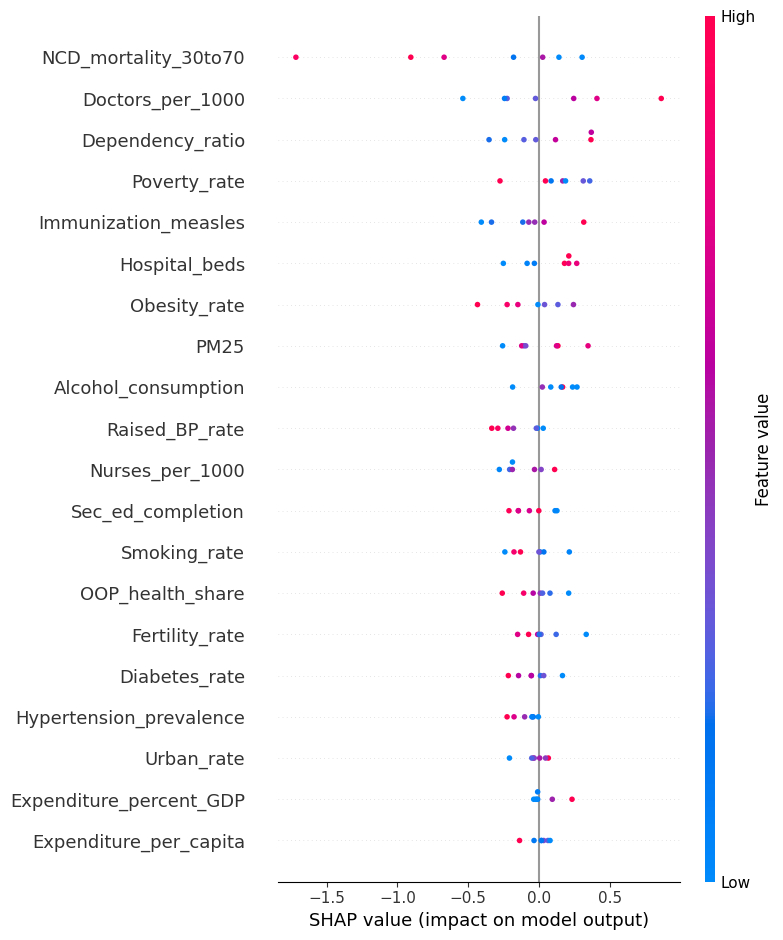

In [203]:
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)


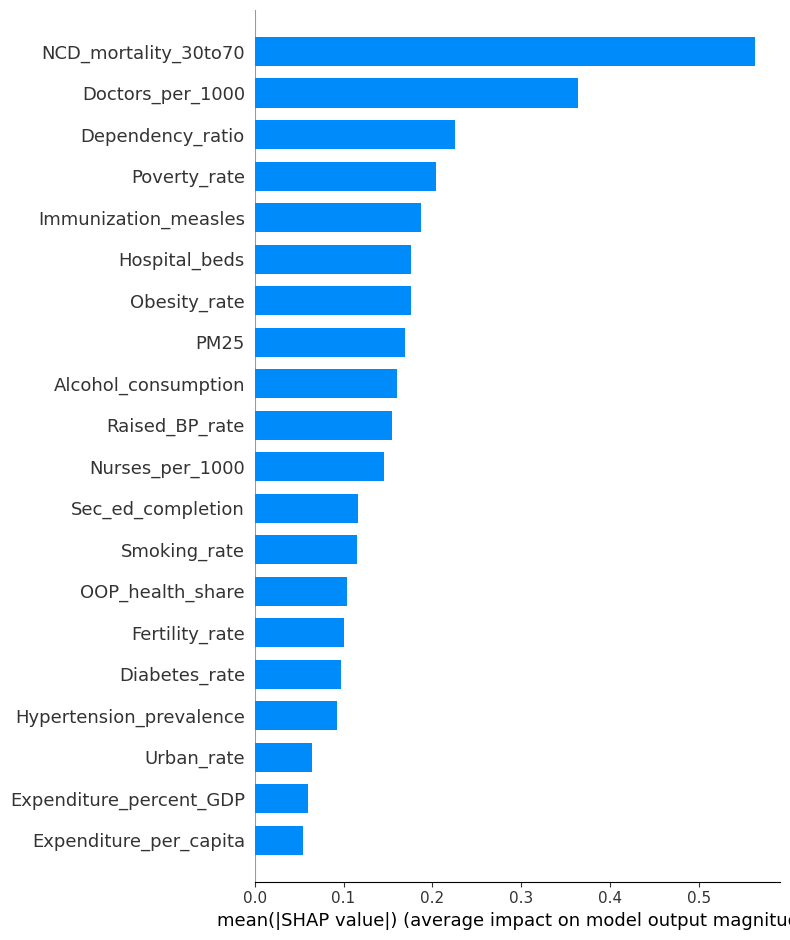

In [204]:
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names, plot_type="bar")


In [205]:
# Overall ranking of countries by efficiency (high = better than expected for income)
ranking = (
    merged[["Country", "HEI_residual_income"]]
    .dropna()
    .sort_values("HEI_residual_income", ascending=False)
    .reset_index(drop=True)
)


In [206]:
ranking = ranking.rename(columns={
    "HEI_residual_income": "HEI_efficiency_score"
})
ranking


,Country,HEI_efficiency_score
0,Japan,4.334914
1,Korea,3.666857
2,Costa Rica,3.138496
3,Portugal,2.838411
4,Israel,2.800898
5,Italy,2.712049
6,Iceland,2.314882
7,Spain,2.041695
8,Chile,2.027640
9,Australia,1.956454


In [207]:
top10 = ranking.head(10)
bottom10 = ranking.tail(10)

print("Top 10 countries by healthcare efficiency (residual LE vs income):")
display(top10)

print("\nBottom 10 countries by healthcare efficiency:")
display(bottom10)


Top 10 countries by healthcare efficiency (residual LE vs income):


,Country,HEI_efficiency_score
0,Japan,4.334914
1,Korea,3.666857
2,Costa Rica,3.138496
3,Portugal,2.838411
4,Israel,2.800898
5,Italy,2.712049
6,Iceland,2.314882
7,Spain,2.041695
8,Chile,2.027640
9,Australia,1.956454



Bottom 10 countries by healthcare efficiency:


,Country,HEI_efficiency_score
28,Türkiye,-1.192969
29,Estonia,-1.352431
30,Slovak Republic,-1.742749
31,Latvia,-2.366488
32,Luxembourg,-2.482445
33,Lithuania,-3.368074
34,Poland,-3.556692
35,Hungary,-4.717065
36,United States,-4.773059
37,Mexico,-8.842735


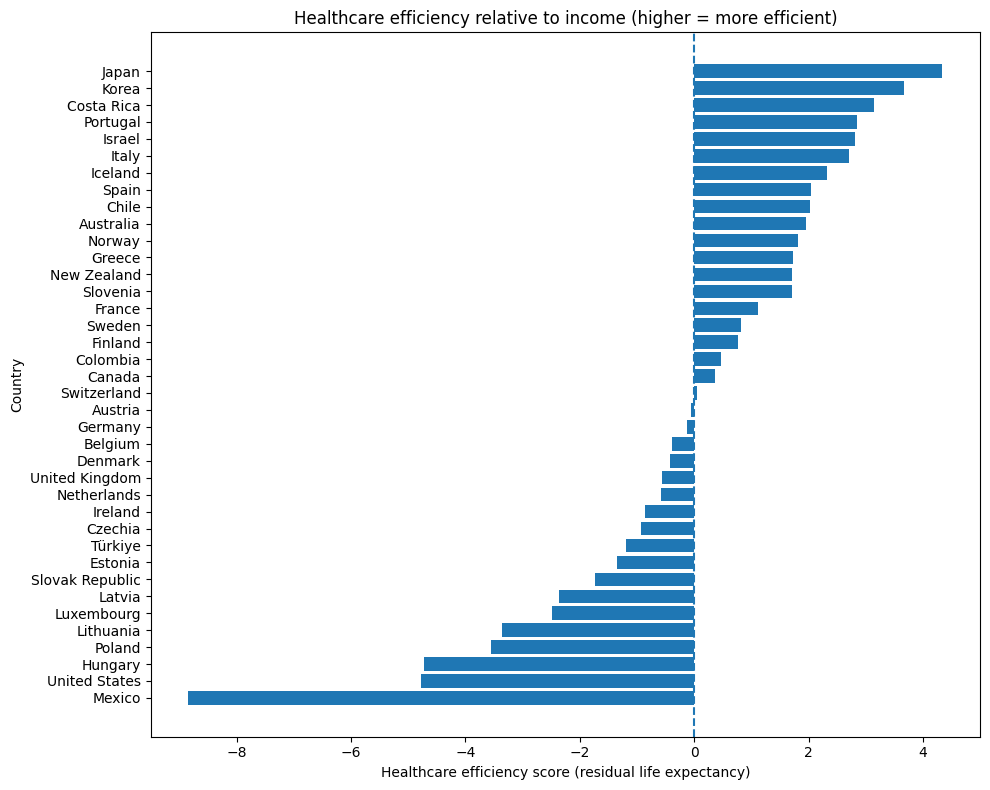

In [208]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# sort again just to be safe
plot_df = ranking.sort_values("HEI_efficiency_score", ascending=True)

plt.barh(plot_df["Country"], plot_df["HEI_efficiency_score"])
plt.axvline(0, linestyle="--")  # zero line (expected performance given income)

plt.xlabel("Healthcare efficiency score (residual life expectancy)")
plt.ylabel("Country")
plt.title("Healthcare efficiency relative to income (higher = more efficient)")
plt.tight_layout()
plt.show()
